In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set()

In [2]:
df = pd.read_csv('output.csv')
df["Correctness_Value"] = df["Correctness"]
df["Correctness"] = df["Correctness"].map({0: "Incorrect", 1:"Correct"})
df['Correctness'] = pd.Categorical(df['Correctness'],
                                   categories=["Correct", "Incorrect"],
                                   ordered=True)
df['Order Difference'] = pd.Categorical(df['Order Difference'],
                                   categories=[-1, 0, 1],
                                   ordered=True)
df['Question ID'] = pd.Categorical(df['Question ID'],
                                   categories=sorted(df['Question ID'].value_counts().keys()),
                                   ordered=True)
df["Given-Expected Answer Pair"] = df.apply(lambda row:(row["Answer"], row["Correct Answer"]), axis=1)
df["Given-Expected Answer Pair"] = pd.Categorical(df["Given-Expected Answer Pair"],
                                                 categories=sorted(df["Given-Expected Answer Pair"].value_counts().keys()),
                                                 ordered=True)

In [4]:
from pymer4.models import Lmer

df_lmer = df[["Participant ID", "Prompt Condition", "Question Type", "Correctness_Value"]]
df_lmer = df_lmer.rename(columns={"Participant ID": "Participant_ID", "Prompt Condition": "Prompt_Condition", "Question Type": "Question_Type"})
df_lmer["Prompt_Condition"] = df_lmer["Prompt_Condition"].map({1:"Blank", 2:"Brief", 3:"Full"})
df_lmer["Question_Type"] = df_lmer["Question_Type"].map({1:"Collect/Share", 2:"Data Type", 3:"Data Purpose"})
# print(df_lmer)
model = Lmer("Correctness_Value ~ Prompt_Condition * Question_Type + (Question_Type|Participant_ID)",
             data=df_lmer, family = 'binomial')
modelFit = model.fit()
print(modelFit)



boundary (singular) fit: see help('isSingular') 

Formula: Correctness_Value~Prompt_Condition*Question_Type+(Question_Type|Participant_ID)

Family: binomial	 Inference: parametric

Number of observations: 5109	 Groups: {'Participant_ID': 126.0}

Log-likelihood: -3080.557 	 AIC: 6191.115

Random effects:

                                     Name    Var    Std
Participant_ID                (Intercept)  0.000  0.000
Participant_ID  Question_TypeData Purpose  0.274  0.523
Participant_ID     Question_TypeData Type  0.209  0.457

                                      IV1                        IV2 Corr
Participant_ID                (Intercept)  Question_TypeData Purpose     
Participant_ID                (Intercept)     Question_TypeData Type     
Participant_ID  Question_TypeData Purpose     Question_TypeData Type  1.0

Fixed effects:

                                                 Estimate  2.5_ci  97.5_ci  \
(Intercept)                                        -0.575  -0.760   -0.390   


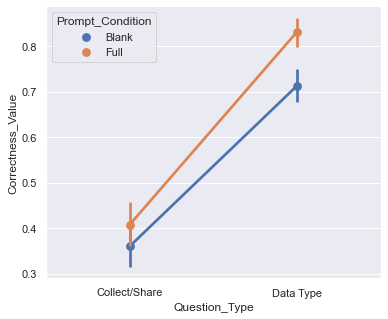

In [8]:
sns.set(rc = {'figure.figsize':(6,5)})
ax = sns.pointplot(x="Question_Type", y="Correctness_Value", hue="Prompt_Condition", data=df_lmer[df_lmer["Prompt_Condition"].isin(["Blank", "Full"]) & df_lmer["Question_Type"].isin(["Collect/Share", "Data Type"])])
plt.savefig("collect_sharextype.png", dpi=300, bbox_inches='tight')

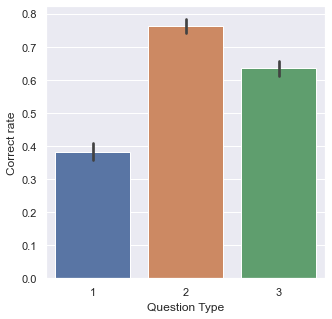

In [62]:
sns.set(rc = {'figure.figsize':(5,5)})
g = sns.barplot(x= "Question Type", y= "Correctness_Value", data=df)
plt.ylabel("Correct rate")
plt.savefig("question_type_correct_rate.png", dpi=300, bbox_inches='tight')

In [5]:
def getRate(df, questionType):
    df = df[df["Question Type"] == questionType]
    df = df[df["Question Category"].str.contains("share basic")]
    df = df[df["Prompt Condition"] == 1]
    types = df["Correctness"].value_counts(normalize=True)
    print(types)
getRate(df, 1)


Correct      0.608696
Incorrect    0.391304
Name: Correctness, dtype: float64


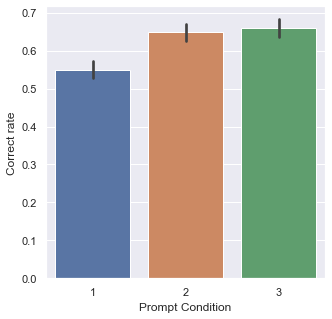

In [63]:
sns.set(rc = {'figure.figsize':(5,5)})
g = sns.barplot(x= "Prompt Condition", y= "Correctness_Value", data=df)
plt.ylabel("Correct rate")
plt.savefig("prompt_condition_correct_rate.png", dpi=300, bbox_inches='tight')

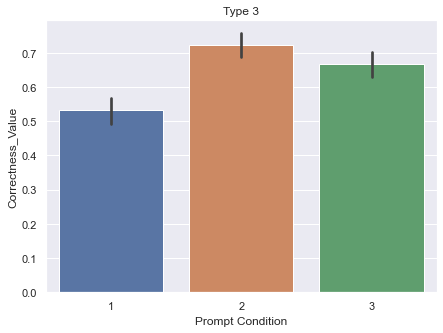

In [46]:
g = sns.barplot(x= "Prompt Condition", y= "Correctness_Value", data=df[df["Question Type"] == 3])
plt.title("Type 3")
plt.savefig("type3Prompt.png")

Text(0.5, 1.0, 'Type 2')

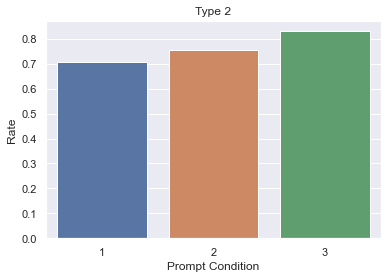

In [7]:
type2 = df[df["Question Type"] == 2]
types = type2.groupby("Prompt Condition")["Correctness"].value_counts(normalize=True)
types = types.drop(labels=['Incorrect'], level = 1)
df1 = pd.DataFrame(types)
df1 = df1.rename(columns={"Correctness" : "Rate"})
g = sns.barplot(x= "Prompt Condition", y= "Rate", data=df1.reset_index())
g.set_title("Type 2")


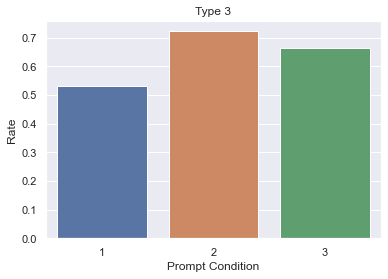

In [5]:
type3 = df[df["Question Type"] == 3]
types = type3.groupby("Prompt Condition")["Correctness"].value_counts(normalize=True)
types = types.drop(labels=['Incorrect'], level = 1)
df1 = pd.DataFrame(types)
df1 = df1.rename(columns={"Correctness" : "Rate"})
g = sns.barplot(x= "Prompt Condition", y= "Rate", data=df1.reset_index())
g.set_title("Type 3")
plt.savefig("type3prompt.png")

-1    0.561086
1     0.438914
0     0.000000
Name: Order Difference, dtype: float64
-1    0.562592
1     0.437408
0     0.000000
Name: Order Difference, dtype: float64


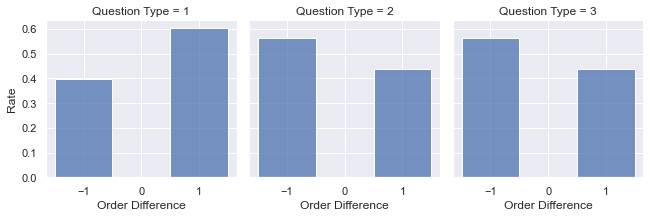

In [20]:
df_incorrect = df[df["Order Difference"] != 0]
print(df_incorrect[df_incorrect["Question Type"] == 2]["Order Difference"].value_counts(normalize=True))
print(df_incorrect[df_incorrect["Question Type"] == 3]["Order Difference"].value_counts(normalize=True))
g = sns.FacetGrid(df_incorrect, col = "Question Type")
graph = g.map_dataframe(sns.histplot, x = "Order Difference", stat="probability")
graph.set_xlabels("Order Difference")
graph.set_ylabels("Rate")

In [9]:
df1 = pd.read_csv('output.csv')
df1["Prompt Condition"] = df1["Prompt Condition"].map({1:"Blank", 2:"Brief", 3:"Full"})

In [10]:
def plot_correct_rate_per_condition(df1, target_question_category):
    type1 = df1[df1["Question Type"] == 1]
    type1 = type1[type1["Question Category"] == target_question_category]
    print(type1.apply(lambda row:row["Question Name"] + row["Prompt Condition"], axis=1).value_counts())
    type1["Question Name"] = type1.apply(lambda row: row["Question Name"].split("Please select")[0], axis=1)
    sns.set(rc = {'figure.figsize':(5,5)})
    g = sns.barplot(y= "Question Name", x= "Correctness", hue = "Prompt Condition", data=type1, orient="h")
    prefix = target_question_category.replace(" ", "_")
    plt.savefig(f"{prefix}_question_correct_rate_per_condition.png", dpi=300, bbox_inches='tight')

In [11]:
def print_count_per_question_condition(df1, target_question_type):
    type1 = df1[df1["Question Type"] == target_question_type]
    type1_dict = type1.apply(lambda row:row["Question Name"] + row["Prompt Condition"], axis=1).value_counts().to_dict()
    print(len(type1_dict.keys()))
    print(type1_dict)

In [69]:
print_count_per_question_condition(df1, 1)

63
{"Our app's user explicitly initiates an action that sends their full name to a third party server. Please select how you would report your app's data practices regarding the user's full name.Blank": 25, "Our app accesses the user’s GPS location and sends it to government agencies in response to a legal request. Please select how you would report our app's data practices regarding the user's GPS location.Blank": 24, "Our app accesses GPS location and sends it to another app directly on the device. The data never leaves the device.(This is feasible because an app can use an Intent to perform some basic interactions with other apps, including sending data) Please select how you would report your app's data practices regarding GPS location.Blank": 24, "Our app accesses GPS location and stores it on Google's server using Google Cloud Storage. (Assume that Google doesn't use the GPS location for other purposes) Please select how you would report our app's data practices regarding the use

In [70]:
print_count_per_question_condition(df1, 2)

231
{"the user's medical recordsBrief": 10, "the user's veteran statusBlank": 10, "in a social media app that you have designed, the user's provided personal bioBlank": 10, "the user's videosBlank": 10, "information about the user's contact recencyBrief": 10, "the user's purchase historyBlank": 10, "the user's personal phone numberBlank": 10, "the user's mailing or home addressBlank": 10, "the user's credit scoreBlank": 10, 'the content of an email sent or received by the userBlank': 10, "information related to the user's  interaction duration with their contactsBlank": 10, "the user's debit card numberBrief": 10, "location provided by Android's ACCESS_COARSE_LOCATIONBlank": 10, 'the content of instant messages/chats sent or received by the userBlank': 10, "in a social media app that you have designed, the user's likesBlank": 9, 'number of times app has crashedBlank': 9, "the user's selection from in-app dialog options.Blank": 9, "names of the user's files and documentsBrief": 9, "the 

In [71]:
print_count_per_question_condition(df1, 3)

45
{"Our map app utilizes the user's location data to get real-time traffic updatesBlank": 45, "Our app utilizes the user device's MAC address in order to isolate suspicious login attempts from new devices.Blank": 45, 'Our app requests that the user provide their email address in order to validate their identity for account creation.Blank': 45, "Our app collects the user's email in order to allow the user to update the account ID they use across all apps created by the same developer.Blank": 45, 'Our app requires that the user provide their phone number, home address, and birthday in order to create a new in-app account.Blank': 45, "Our app collects the user's email address for log-in purposesBlank": 45, 'Our podcast app collects data about podcasts each user has listened to in order to suggest podcasts the user might like.Blank': 45, "Our shopping app collects data related to the user's previous purchases to suggest new products on our site that might appeal to them.Blank": 45, "Our w

Our app accesses GPS location and sends it to our server. Please select how you would report our app's data practices regarding GPS location.Blank    22
Our app accesses GPS location and sends it to our server. Please select how you would report our app's data practices regarding GPS location.Full     20
Our app accesses GPS location and sends it to our server. Please select how you would report our app's data practices regarding GPS location.Brief    18
dtype: int64


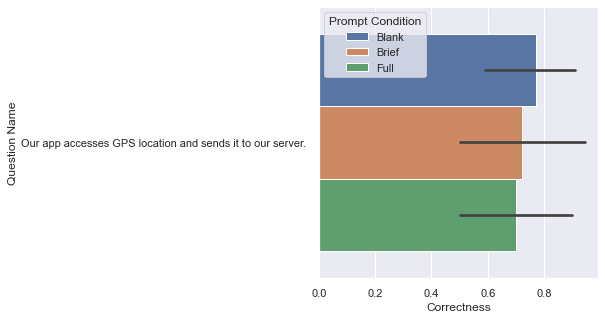

In [72]:
plot_correct_rate_per_condition(df1, "collect basic")

Our app accesses GPS location and sends it to our server via libraries and/or SDKs included in our app. Please select how you would report our app's data practices regarding GPS location.Blank                                                                                                                                                                   23
Our app sends the user's GPS location to our server to search for nearby places but does not store the GPS location after serving the request. Please select how you would report our app's data practices regarding the user's GPS location.Blank                                                                                                                 23
Our app requests for the user's full name and only sends the pseudonymized name to our server. (A pseudonymized name does not allow the individual to be directly identified, but it can be re-associated with the user if additional information is provided) Please select how you would r

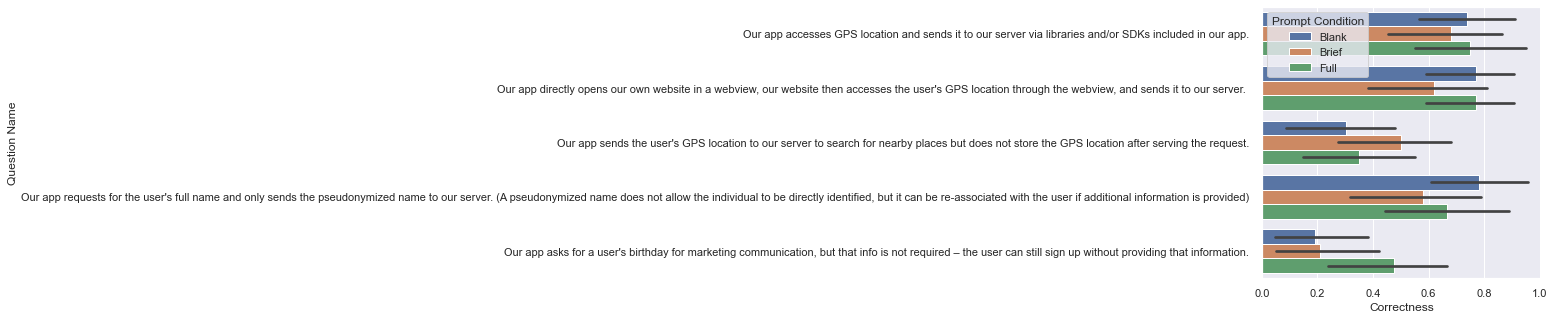

In [73]:
plot_correct_rate_per_condition(df1, "collect special")

Our app allows users to navigate the open web via a webview. When the user opens google.com, it accesses the user's GPS location and sends the GPS location to Google's server.  Please select how you would report our app's data practices regarding GPS location.Blank    24
Our app encrypts the user’s message before it is sent to another user, where it is decrypted. Please select how you would report our app's data practices regarding the user's messages.Blank                                                                                23
Our app accesses and processes the user's GPS location directly on the user’s device. The data never leaves the device. Please select how you would report our app's data practices regarding the user's GPS location.Blank                                                  22
Our app accesses and processes the user's GPS location directly on the user’s device. The data never leaves the device. Please select how you would report our app's data practices rega

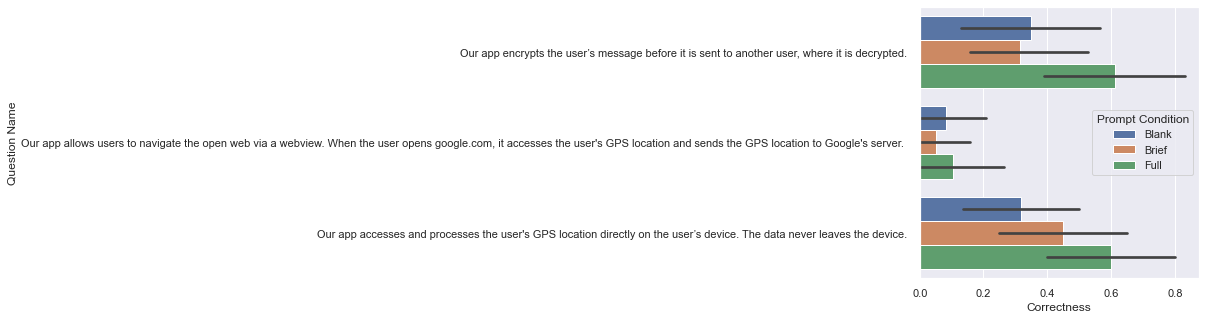

In [12]:
plot_correct_rate_per_condition(df1, "collect exempt")

Our app accesses GPS location and sends it to a third party server. Please select how you would report our app's data practices regarding GPS location.Blank    22
Our app accesses GPS location and sends it to a third party server. Please select how you would report our app's data practices regarding GPS location.Brief    22
Our app accesses GPS location and sends it to a third party server. Please select how you would report our app's data practices regarding GPS location.Full     20
dtype: int64


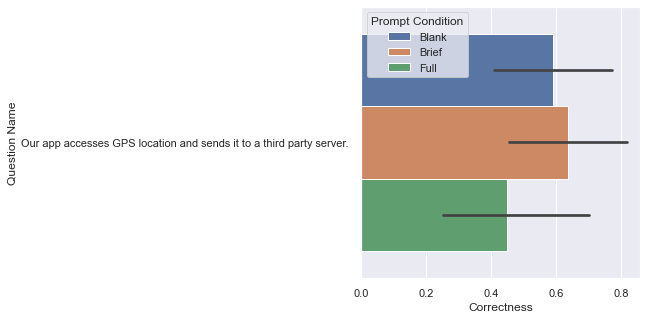

In [74]:
plot_correct_rate_per_condition(df1, "share basic")

Our app accesses GPS location and sends it to another app directly on the device. The data never leaves the device.(This is feasible because an app can use an Intent to perform some basic interactions with other apps, including sending data) Please select how you would report your app's data practices regarding GPS location.Blank    24
Our app directly opens our own website in a webview, our website accesses the GPS location through the webview, and sends it to a third party server.  Please select how you would report your app's data practices regarding GPS location.Blank                                                                                               23
Our app accesses GPS location and sends it directly to a third party server via libraries and/or SDKs included in our app. Please select how you would report our app's data practices regarding GPS location.Full                                                                                                                  

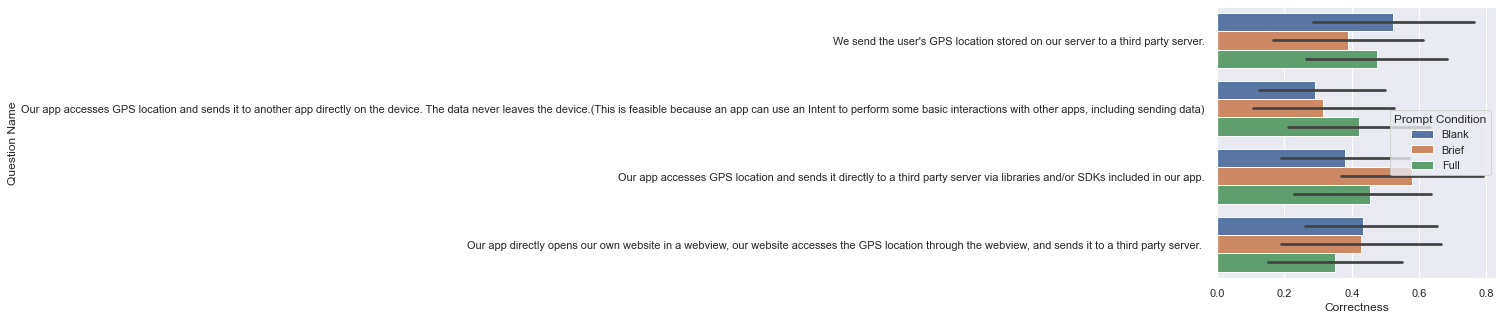

In [85]:
plot_correct_rate_per_condition(df1, "share special")

Our app's user explicitly initiates an action that sends their full name to a third party server. Please select how you would report your app's data practices regarding the user's full name.Blank                                                                                    25
Our app accesses the user’s GPS location and sends it to government agencies in response to a legal request. Please select how you would report our app's data practices regarding the user's GPS location.Blank                                                                       24
Our app accesses GPS location and stores it on Google's server using Google Cloud Storage. (Assume that Google doesn't use the GPS location for other purposes) Please select how you would report our app's data practices regarding the user's GPS location.Blank                    24
Our app allows users to navigate the open web via a webview. When the user opens google.com, it accesses the user's GPS location and sends the GPS locatio

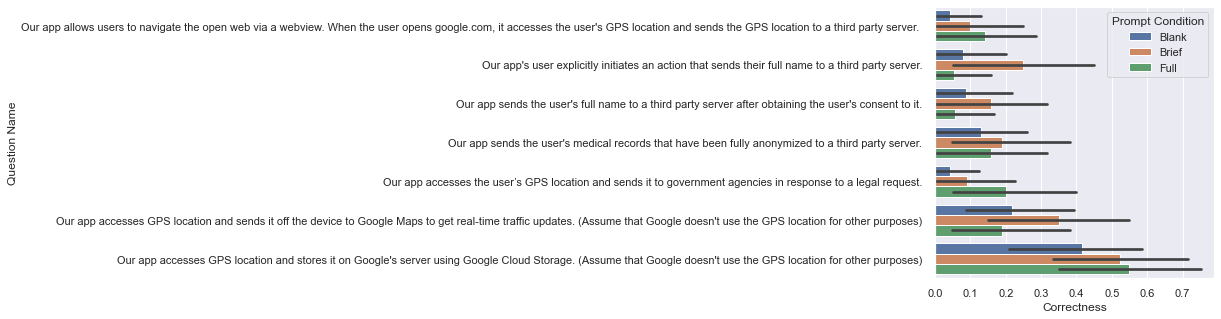

In [13]:
plot_correct_rate_per_condition(df1, "share exempt")

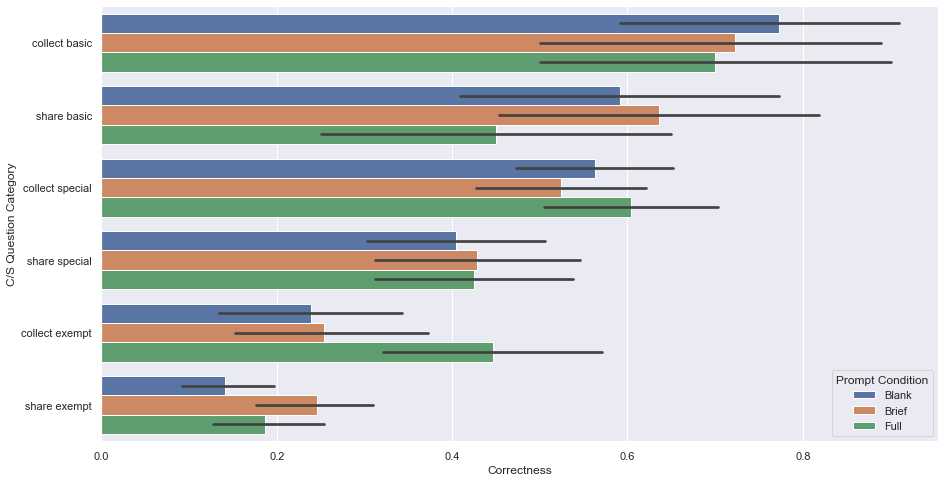

In [6]:
type1 = df1[df1["Question Type"] == 1]
type1 = type1.rename(columns={"Correctness Value" : "Correct Rate", "Question Category": "C/S Question Category"})
sns.set(rc = {'figure.figsize':(15,8)})
g = sns.barplot(y= "C/S Question Category", x= "Correctness", hue = "Prompt Condition", data=type1, orient="h", order=["collect basic", "share basic", "collect special", "share special", "collect exempt", "share exempt"])
plt.savefig("collect_share_question_category_correct_rate.pdf", bbox_inches='tight')
plt.savefig("collect_share_question_category_correct_rate.png", dpi=300, bbox_inches='tight')

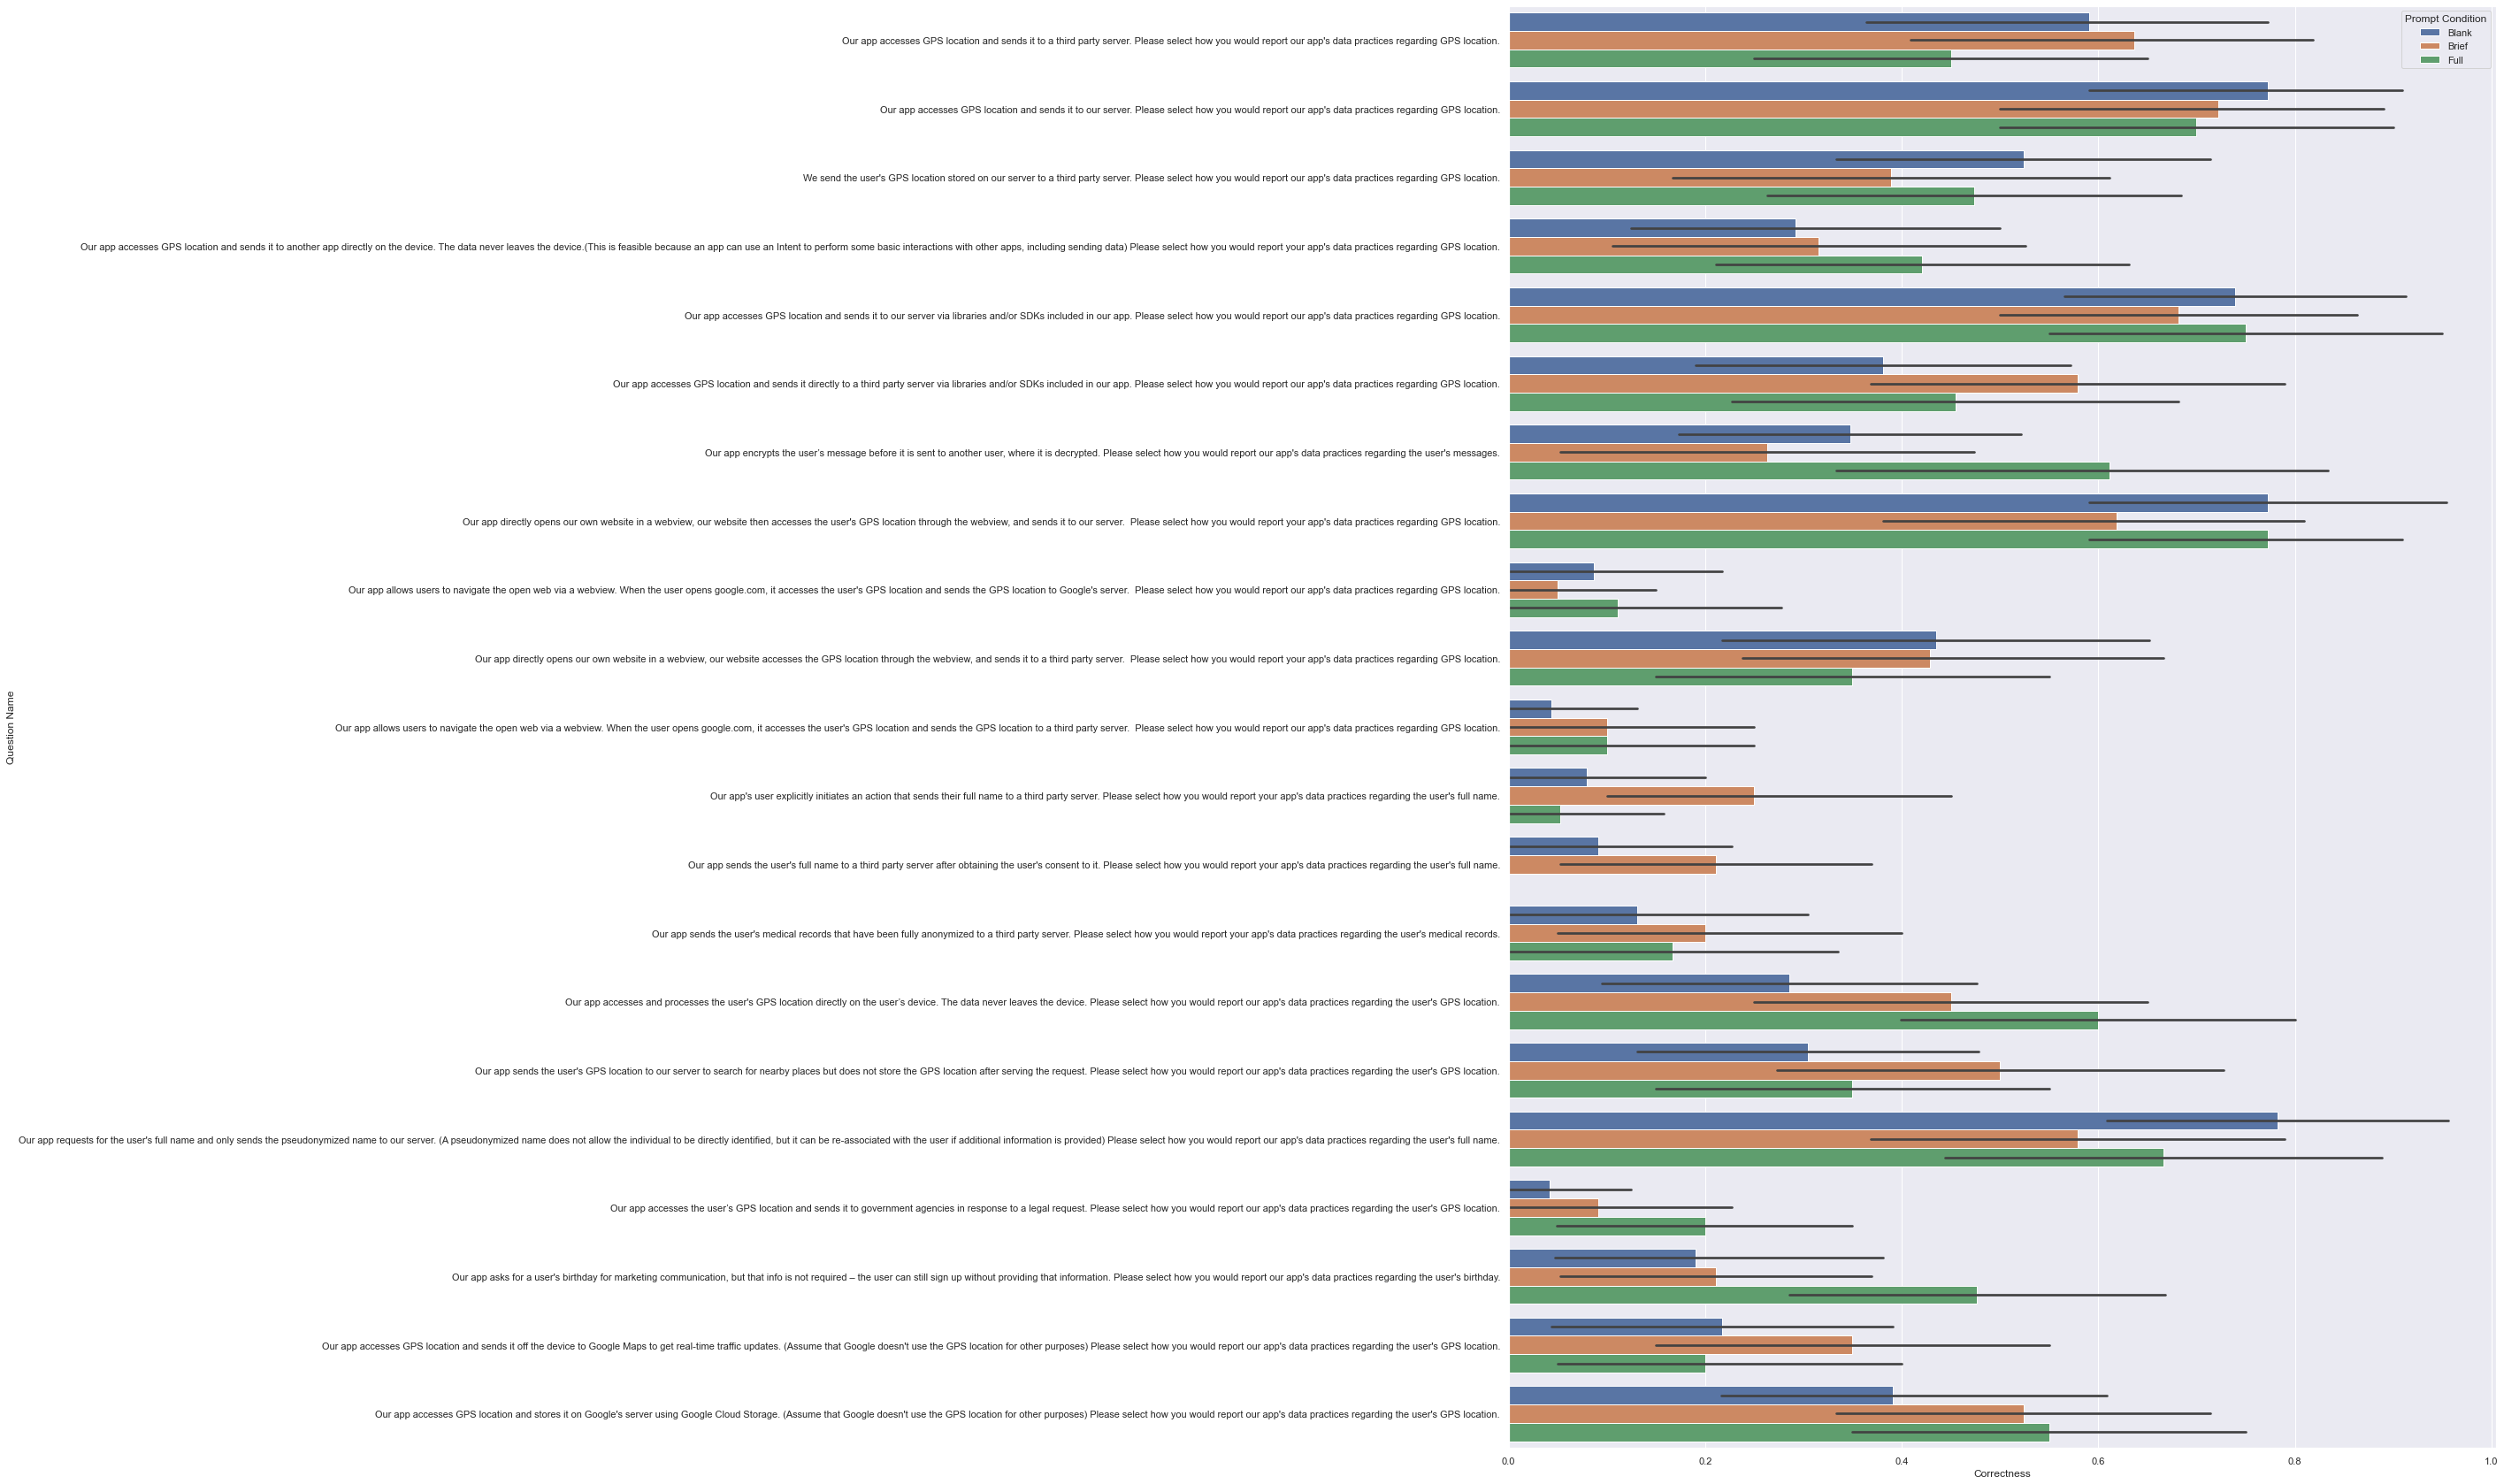

In [7]:
type1 = df1[df1["Question Type"] == 1]
sns.set(rc = {'figure.figsize':(20,30)})
g = sns.barplot(y= "Question Name", x= "Correctness", hue = "Prompt Condition", data=type1, orient='h')
fig = g.get_figure()
fig.savefig("type1.png", bbox_inches="tight")


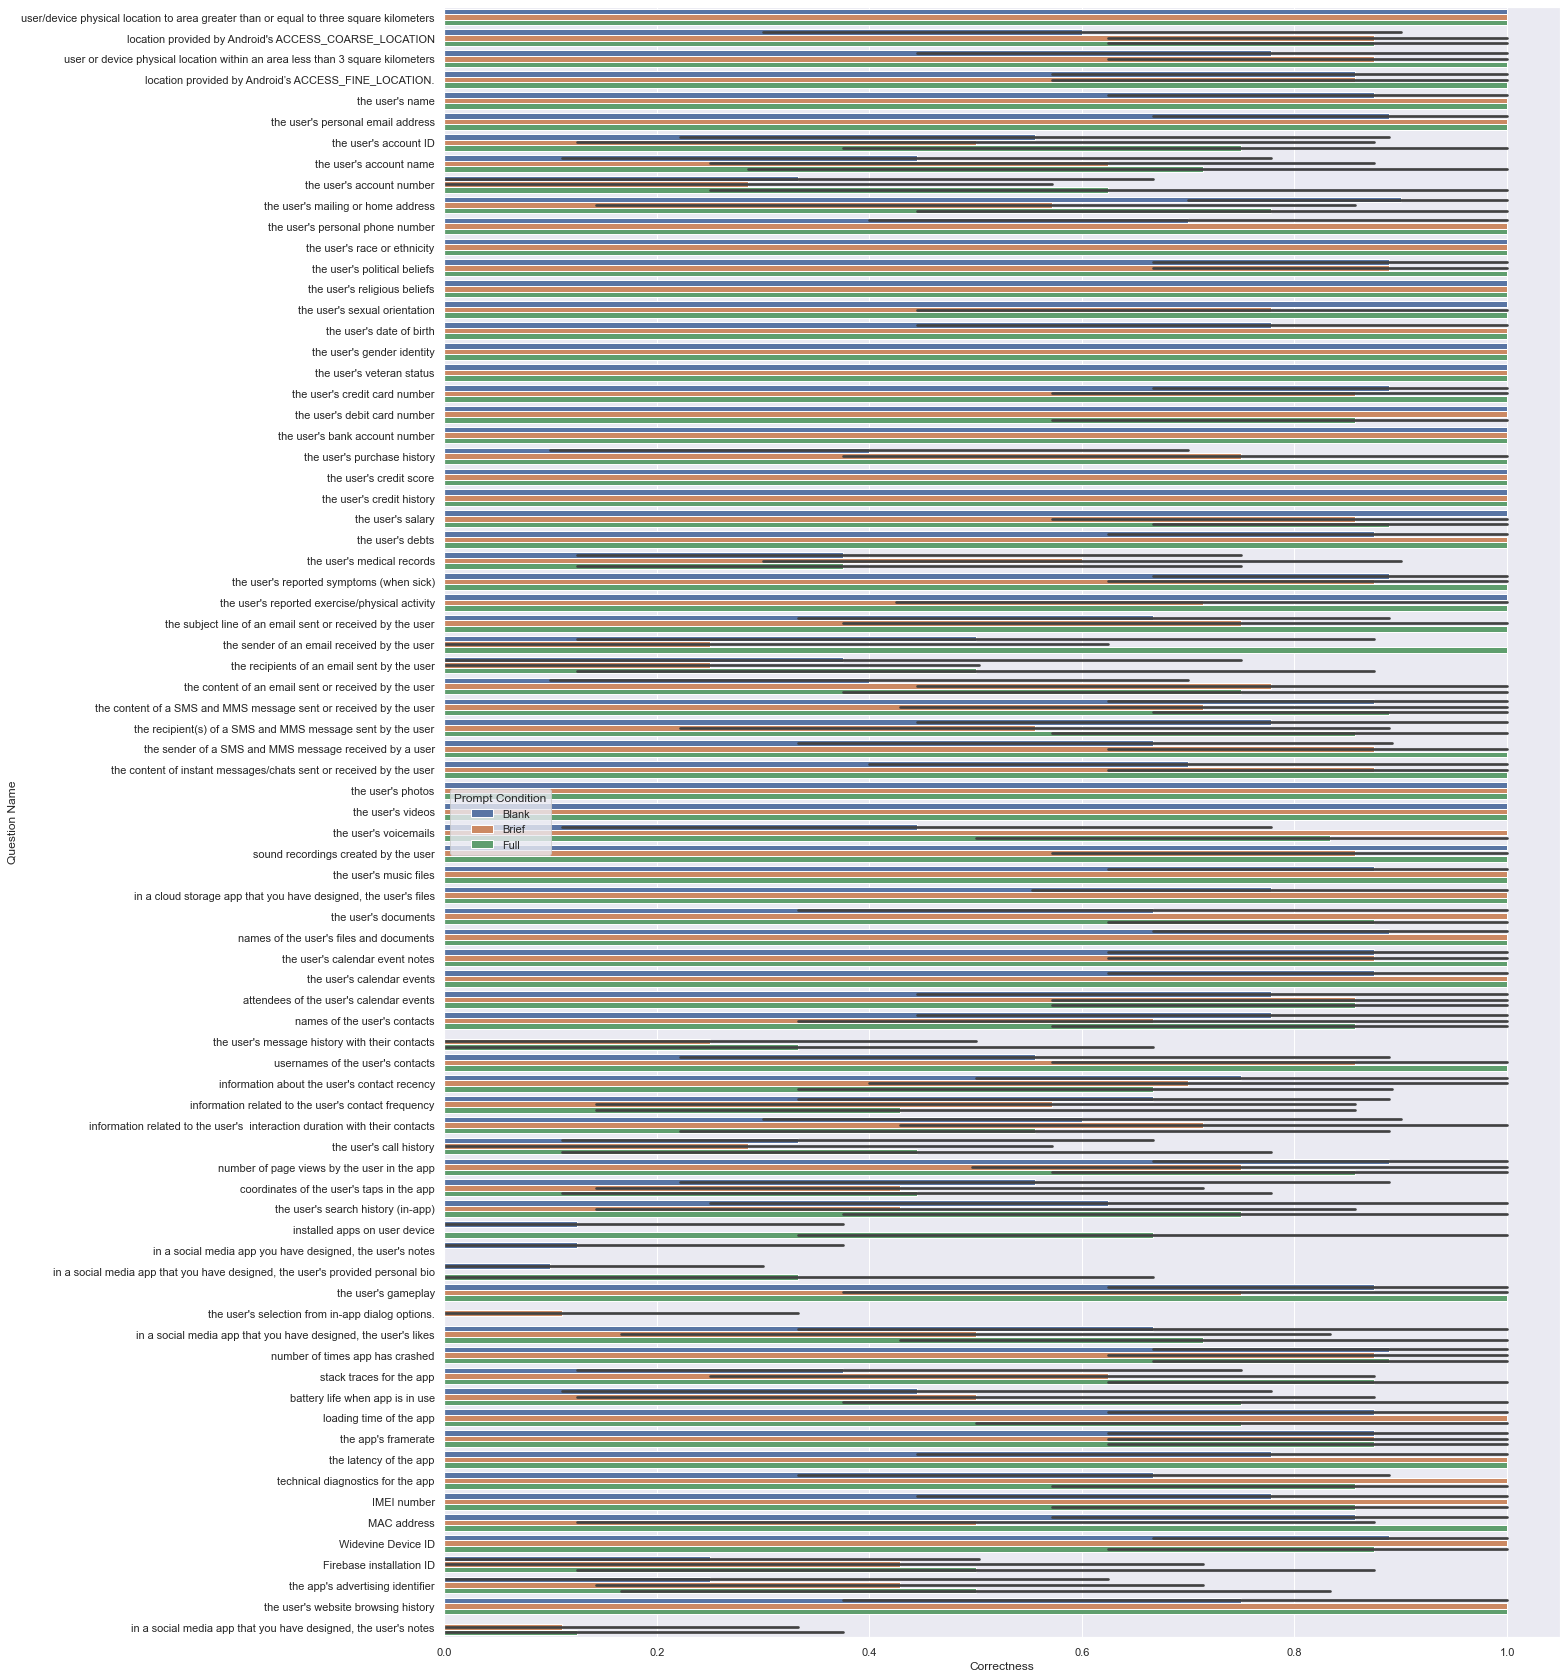

In [8]:
type2 = df1[df1["Question Type"] == 2]
sns.set(rc = {'figure.figsize':(20,30)})
g = sns.barplot(y= "Question Name", x= "Correctness", hue = "Prompt Condition", data=type2, orient='h')
fig = g.get_figure()
fig.savefig("type2.png", bbox_inches="tight")

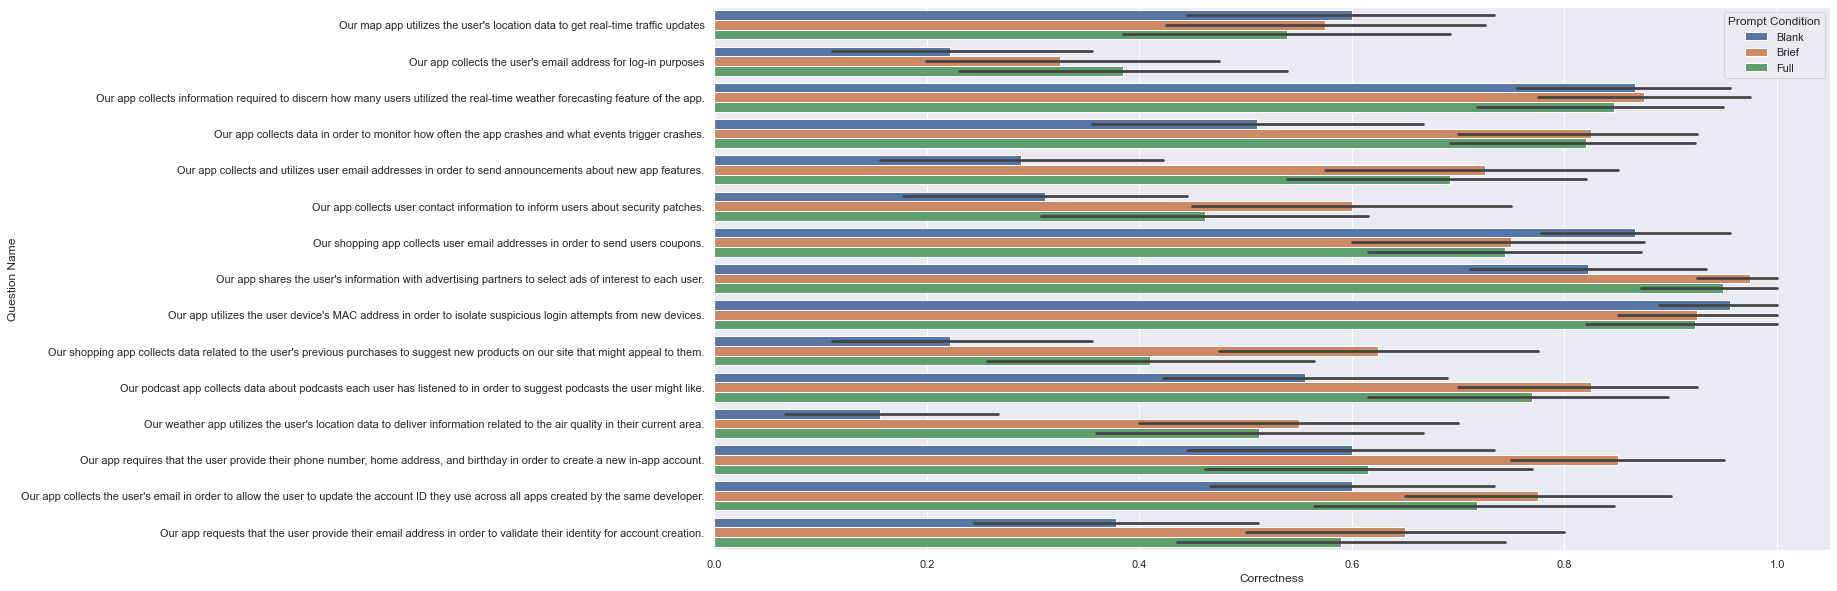

In [9]:
type3 = df1[df1["Question Type"] == 3]
sns.set(rc = {'figure.figsize':(20,10)})
g = sns.barplot(y= "Question Name", x= "Correctness", hue = "Prompt Condition", data=type3, orient="h")
fig = g.get_figure()
fig.savefig("type3.png", bbox_inches="tight")

In [619]:
df = pd.read_csv('output.csv')
df["Correctness"] = df["Correctness"].map({0: "Incorrect", 1:"Correct"})
df['Correctness'] = pd.Categorical(df['Correctness'],
                                   categories=["Correct", "Incorrect"],
                                   ordered=True)
df['Order Difference'] = pd.Categorical(df['Order Difference'],
                                   categories=[-1, 0, 1],
                                   ordered=True)
df["Given-Expected Answer Pair"] = df.apply(lambda row:(row["Answer"], row["Correct Answer"]), axis=1)


Text(0.5, 0.98, 'Given-Expected Answer Pair')

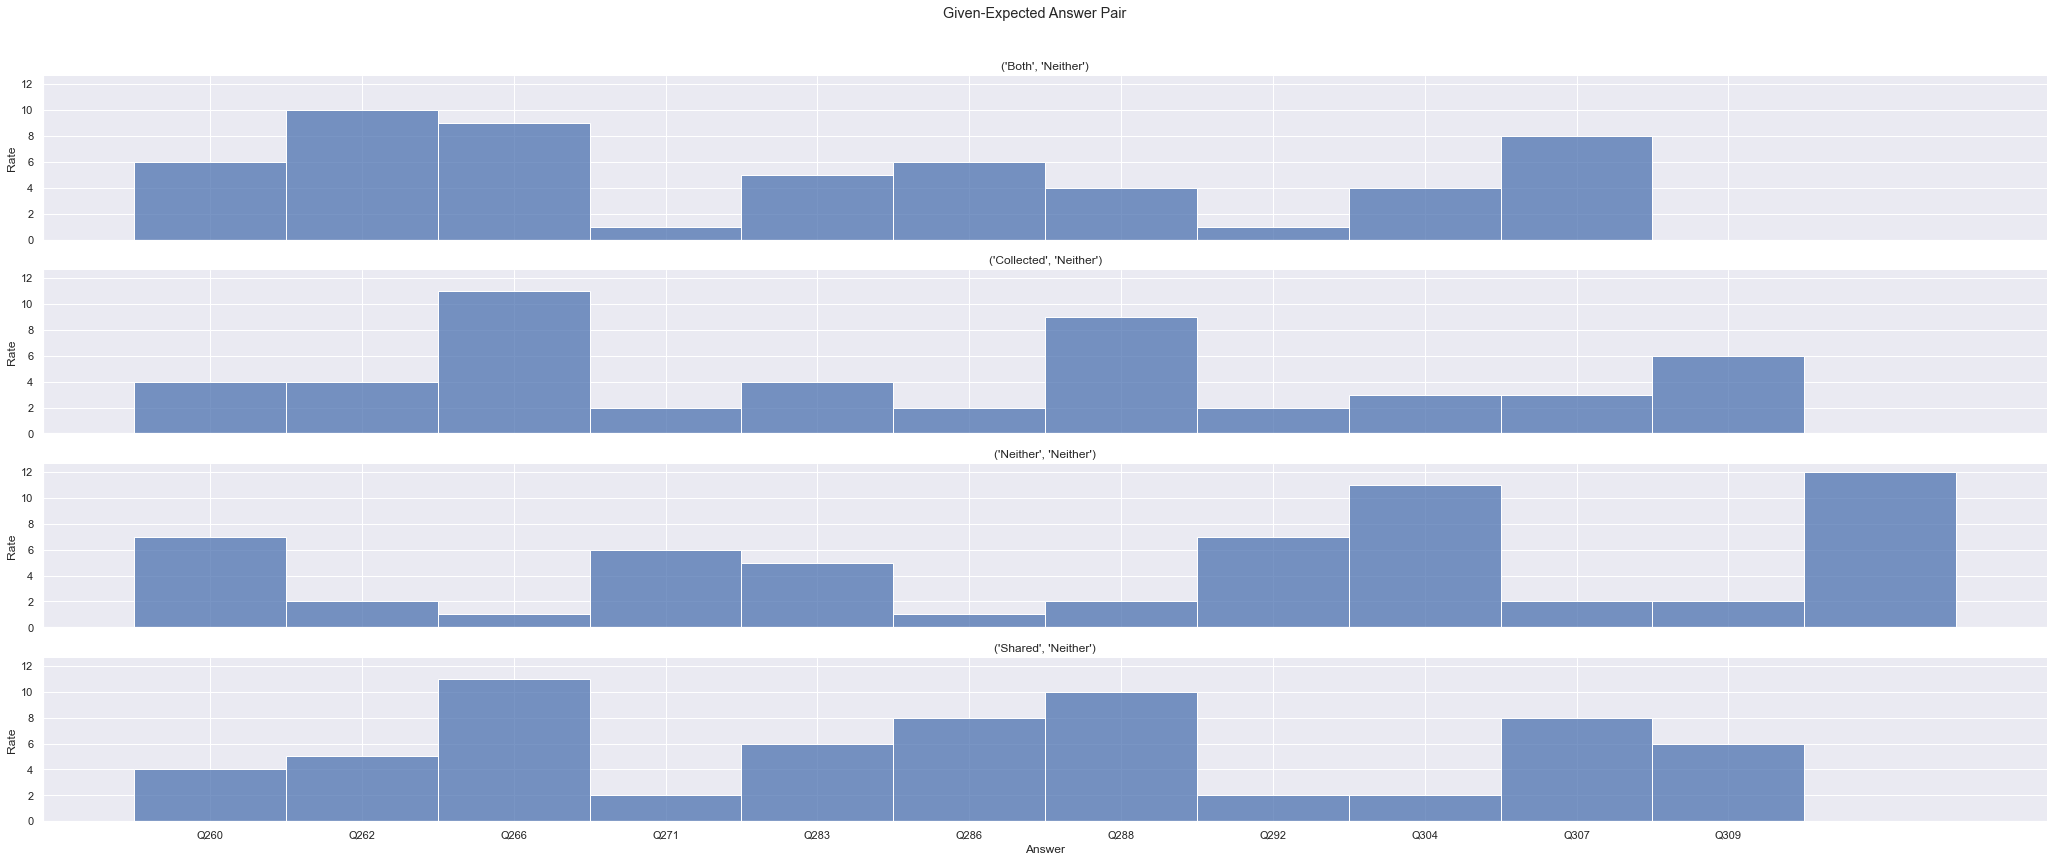

In [620]:
g = sns.FacetGrid(df[df["Correct Answer"] == "Neither"], col = "Given-Expected Answer Pair", col_wrap=1, aspect=9.5,
                 col_order=sorted(df[df["Correct Answer"] == "Neither"]["Given-Expected Answer Pair"].value_counts().keys()))
graph = g.map_dataframe(sns.histplot, x = "Question ID", stat="count")
graph.set_xlabels("Answer")
graph.set_ylabels("Rate")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Add a title for the entire plot
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Given-Expected Answer Pair")

                                            Description     Answer  \
182   Data usage scenario: Our app allows users to n...  Collected   
183   Data usage scenario: Our app allows users to n...       Both   
184   Data usage scenario: Our app allows users to n...    Neither   
185   Data usage scenario: Our app allows users to n...     Shared   
186   Data usage scenario: Our app allows users to n...    Neither   
...                                                 ...        ...   
3781  Data usage scenario: Our app accesses and proc...    Neither   
3782  Data usage scenario: Our app accesses and proc...    Neither   
3783  Data usage scenario: Our app accesses and proc...  Collected   
3784  Data usage scenario: Our app accesses and proc...     Shared   
3785  Data usage scenario: Our app accesses and proc...  Collected   

     Correct Answer Question Category  
182         Neither    collect exempt  
183         Neither    collect exempt  
184         Neither    collect exempt  

[Text(0.5, 21.5, 'Answer'), Text(80.18000000000006, 0.5, 'Correct Answer')]

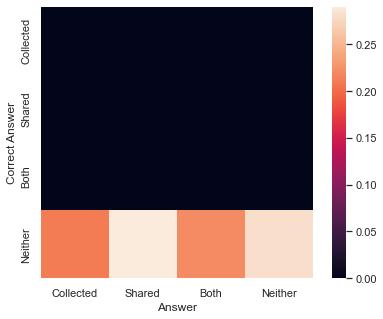

In [28]:
t1 = pd.read_csv('output.csv', usecols = [3, 4, 5, 7])
t1 = t1[t1["Question Category"]== "collect exempt"]
t1 = t1[t1["Description"].str.contains("webview")]
print(t1)
correctTotals = dict()
correctAnswers = t1.loc[:, "Correct Answer"]
actualAnswers = t1.loc[:, "Answer"]
answerPairs = dict()
for (i,j) in zip(correctAnswers, actualAnswers):
    correctTotals[i]= correctTotals.get(i, 0) + 1
    answerPairs[(i, j)] = answerPairs.get((i, j), 0) + 1
#create ratios for actual/correct answers
for (correct, actual) in answerPairs:
    answerPairs[(correct, actual)] = answerPairs[(correct, actual)] / correctTotals[correct]
rowNames = ["Collected", "Shared", "Both", "Neither"]
type1 = pd.DataFrame(columns=rowNames, index=rowNames)
for i in range(len(rowNames)):
    for j in range(len(rowNames)):
        if (rowNames[i], rowNames[j]) in answerPairs:
            type1.at[rowNames[i], rowNames[j]] = answerPairs[(rowNames[i], rowNames[j])]
        else:
            type1.at[rowNames[i], rowNames[j]] = 0
type1 = type1.astype(float)
print(type1)
sns.set(rc = {'figure.figsize':(7,5)})
g = sns.heatmap(type1, square=True)
g.set(xlabel= "Answer", ylabel = "Correct Answer")

           Collected    Shared      Both   Neither
Collected   0.393372  0.279539  0.244957  0.082133
Shared      0.157895  0.315789  0.210526  0.315789
Both        0.108225  0.415584  0.467532  0.008658
Neither     0.221239  0.283186  0.238938  0.256637


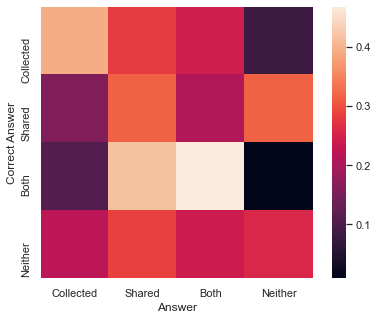

In [621]:
t1 = pd.read_csv('output.csv', usecols = [4, 5, 6])
t1 = t1[t1["Question Type"] == 1]
t1 = t1.drop("Question Type", 1)
correctTotals = dict()
correctAnswers = t1.loc[:, "Correct Answer"]
actualAnswers = t1.loc[:, "Answer"]
answerPairs = dict()
for (i,j) in zip(correctAnswers, actualAnswers):
    correctTotals[i]= correctTotals.get(i, 0) + 1
    answerPairs[(i, j)] = answerPairs.get((i, j), 0) + 1
#create ratios for actual/correct answers
for (correct, actual) in answerPairs:
    answerPairs[(correct, actual)] = answerPairs[(correct, actual)] / correctTotals[correct]
rowNames = ["Collected", "Shared", "Both", "Neither"]
type1 = pd.DataFrame(columns=rowNames, index=rowNames)
for i in range(len(rowNames)):
    for j in range(len(rowNames)):
        if (rowNames[i], rowNames[j]) in answerPairs:
            type1.at[rowNames[i], rowNames[j]] = answerPairs[(rowNames[i], rowNames[j])]
        else:
            type1.at[rowNames[i], rowNames[j]] = 0
type1 = type1.astype(float)
print(type1)
sns.set(rc = {'figure.figsize':(7,5)})
g = sns.heatmap(type1, square=True)
g.set(xlabel= "Answer", ylabel = "Correct Answer")
plt.savefig("collect_sharing_heatmap.pdf", bbox_inches='tight')
plt.savefig("collect_sharing_heatmap.png", dpi=300, bbox_inches='tight')

/var/folders/48/wxggm2pd44bg0sl0_g9ttrd00000gn/T/ipykernel_37669/1939946031.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  t2 = t2.drop("Question Type", 1)


                                 Location  Personal Information  \
Location                         0.880435              0.032609   
Personal Information             0.017341              0.843931   
Financial Information            0.000000              0.030000   
Health and Fitness               0.000000              0.205128   
Messages                         0.000000              0.117647   
Photos or Videos                 0.000000              0.000000   
Audio Files                      0.000000              0.028571   
Files and docs                   0.000000              0.068493   
Calendar                         0.000000              0.042254   
Contacts                         0.005814              0.127907   
App Activity                     0.020942              0.157068   
Web Browsing                     0.000000              0.076923   
App Information and Performance  0.014925              0.009950   
Device or Other Identifiers      0.008621              0.05172

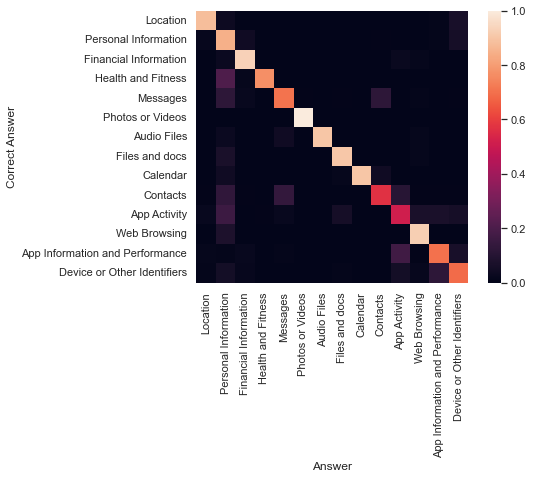

In [3]:
t2 = pd.read_csv('output.csv', usecols = [4, 5, 6])
t2 = t2[t2["Question Type"] == 2]
t2 = t2.drop("Question Type", 1)
correctTotals = dict()
correctAnswers = t2.loc[:, "Correct Answer"]
actualAnswers = t2.loc[:, "Answer"]
answerPairs = dict()
for (i,j) in zip(correctAnswers, actualAnswers):
    correctTotals[i]= correctTotals.get(i, 0) + 1
    answerPairs[(i, j)] = answerPairs.get((i, j), 0) + 1
#create ratios for actual/correct answers
for (correct, actual) in answerPairs:
    answerPairs[(correct, actual)] = answerPairs[(correct, actual)] / correctTotals[correct]
rowNames = ["Location", "Personal Information", "Financial Information", "Health and Fitness", "Messages", "Photos or Videos", "Audio Files", "Files and docs", "Calendar", "Contacts", "App Activity", "Web Browsing", "App Information and Performance", "Device or Other Identifiers"]
type2 = pd.DataFrame(columns=rowNames, index=rowNames)
for i in range(len(rowNames)):
    for j in range(len(rowNames)):
        if (rowNames[i], rowNames[j]) in answerPairs:
            type2.at[rowNames[i], rowNames[j]] = answerPairs[(rowNames[i], rowNames[j])]
        else:
            type2.at[rowNames[i], rowNames[j]] = 0
type2 = type2.astype(float)
print(type2)
sns.set(rc = {'figure.figsize':(7,5)})
g = sns.heatmap(type2, square=True)
g.set(xlabel= "Answer", ylabel = "Correct Answer")
plt.savefig("data_type_heatmap.pdf", bbox_inches='tight')
plt.savefig("data_type_heatmap.png", dpi=300, bbox_inches='tight')

/var/folders/48/wxggm2pd44bg0sl0_g9ttrd00000gn/T/ipykernel_705/4032896247.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  t3 = t3.drop("Question Type", 1)


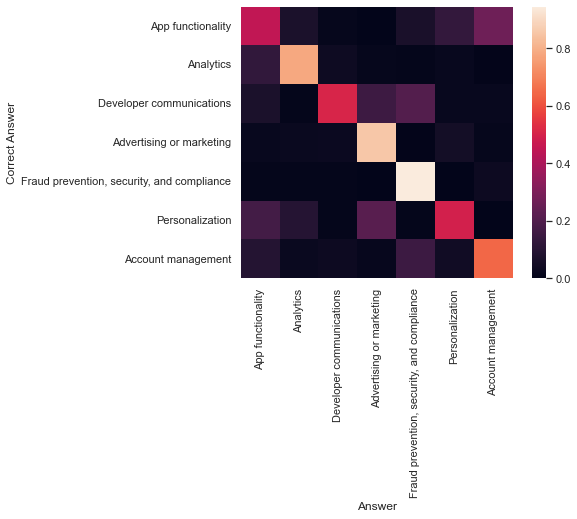

In [48]:
t3 = pd.read_csv('output.csv', usecols = [4, 5, 6])
t3 = t3[t3["Question Type"] == 3]
t3 = t3.drop("Question Type", 1)
correctTotals = dict()
correctAnswers = t3.loc[:, "Correct Answer"]
actualAnswers = t3.loc[:, "Answer"]
answerPairs = dict()
for (i,j) in zip(correctAnswers, actualAnswers):
    correctTotals[i]= correctTotals.get(i, 0) + 1
    answerPairs[(i, j)] = answerPairs.get((i, j), 0) + 1
#create ratios for actual/correct answers
for (correct, actual) in answerPairs:
    answerPairs[(correct, actual)] = answerPairs[(correct, actual)] / correctTotals[correct]
rowNames = ["App functionality", "Analytics", "Developer communications", "Advertising or marketing", "Fraud prevention, security, and compliance", "Personalization", "Account management"]
type3 = pd.DataFrame(columns=rowNames, index=rowNames)
for i in range(len(rowNames)):
    for j in range(len(rowNames)):
        if (rowNames[i], rowNames[j]) in answerPairs:
            type3.at[rowNames[i], rowNames[j]] = answerPairs[(rowNames[i], rowNames[j])]
        else:
            type3.at[rowNames[i], rowNames[j]] = 0
type3 = type3.astype(float)
type3.to_csv("type3.csv")
sns.set(rc = {'figure.figsize':(7,5)})
g = sns.heatmap(type3, square=True)
g.set(xlabel= "Answer", ylabel = "Correct Answer")
plt.savefig("data_purpose_heatmap.png", dpi=300, bbox_inches='tight')